In [1]:
# Source: https://github.com/ramprs/grad-cam/blob/master/captioning.lua

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from transformers import BlipProcessor, BlipForConditionalGeneration

c:\Users\rlawl\anaconda3\envs\kim\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Settings & Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

image_file = "images/zebra.jpg"
output_dir = "./results/image_captioning"
os.makedirs(output_dir, exist_ok=True)
image_name = os.path.splitext(os.path.basename(image_file))[0]

# Create a dummy image (if it doesn't exist)
if not os.path.exists(image_file):
    os.makedirs(os.path.dirname(image_file), exist_ok=True)
    Image.new('RGB', (384, 384), color='white').save(image_file)

Using device: cpu


In [3]:
# --- Load Pre-trained Model (BLIP) ---
# Load pre-trained BLIP model from Salesforce (auto-download)
model_id = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(model_id, use_fast=True)
model = BlipForConditionalGeneration.from_pretrained(model_id).to(device)

# Set model to eval mode for Grad-CAM (gradients are still tracked)
model.eval()

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [4]:
# --- Hook Configuration for ViT ---
# Target the last layer of BLIP's vision model (ViT)
# vision_model.encoder.layers[-1] (Last encoder block) -> layer_norm1 (Before attention)
target_layer = model.vision_model.encoder.layers[-1].layer_norm1
print(f"Target layer: {target_layer}")

values = {'activations': None, 'gradients': None}

# ViT output is (Batch, Seq, Dim), need to reshape to (Batch, Dim, H, W) like CNN
def reshape_transform(tensor, height=24, width=24):
    # tensor: (Batch, Seq_len, Dim) -> (Batch, Dim, Seq_len)
    # Seq_len = 577 (1 cls_token + 24*24 patches)
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    # (Batch, H, W, Dim) -> (Batch, Dim, H, W)
    result = result.permute(0, 3, 1, 2)
    return result

def hook_forward(module, input, output):
    values['activations'] = reshape_transform(output.detach())

def hook_backward(module, grad_input, grad_output):
    values['gradients'] = reshape_transform(grad_output[0].detach())

# Register hooks
target_layer.register_forward_hook(hook_forward)
target_layer.register_full_backward_hook(hook_backward)

Target layer: LayerNorm((768,), eps=1e-05, elementwise_affine=True)


In [5]:
# --- Preprocessing & Caption Generation ---
raw_image = Image.open(image_file).convert('RGB')
# BLIP uses 384x384 resolution by default
inputs = processor(raw_image, return_tensors="pt").to(device)

# Caption Generation (Inference)
with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=20)
    caption = processor.decode(generated_ids[0], skip_special_tokens=True)
    print(f"Generated Caption: {caption}")

# --- Gradient Calculation ---
# Set the generated caption as the label and perform backpropagation for Grad-CAM
model.zero_grad()

# Perform Forward Pass again using generated caption IDs as input (Track gradients)
# input_ids are decoder inputs, labels are for loss calculation
text_ids = generated_ids.to(device)
outputs = model(input_ids=text_ids, pixel_values=inputs.pixel_values, labels=text_ids)
loss = outputs.loss

# Backward Pass (Compute gradients for loss)
loss.backward()

# --- Grad-CAM Calculation ---
gradients = values['gradients']     # [1, 768, 24, 24]
activations = values['activations'] # [1, 768, 24, 24]

# Global Average Pooling on Gradients
weights = torch.mean(gradients, dim=(2, 3), keepdim=True) # [1, 768, 1, 1]

# Linear combination
grad_cam = torch.sum(weights * activations, dim=1).squeeze() # [24, 24]
grad_cam = F.relu(grad_cam)

# Normalization
grad_cam = grad_cam.cpu().numpy()
grad_cam -= np.min(grad_cam)
if np.max(grad_cam) != 0:
    grad_cam /= np.max(grad_cam)

Generated Caption: two zebras in the wild


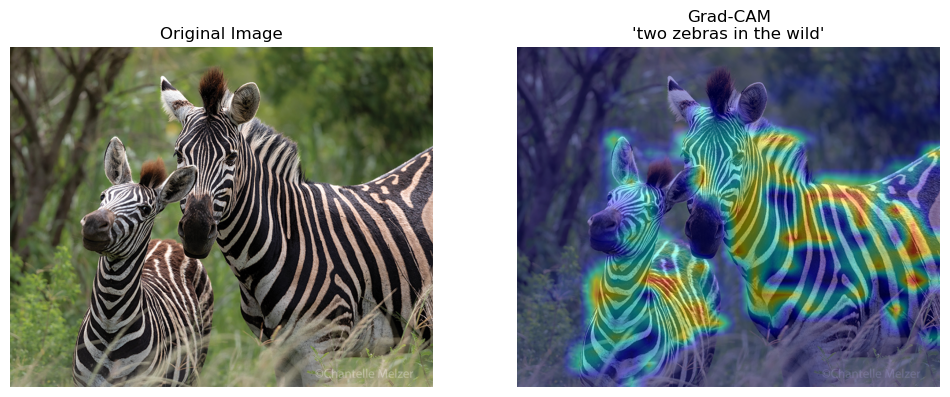

Result saved at: ./results/image_captioning\image_captioning_zebra.png


In [6]:
# --- Visualization ---
# Resize heatmap to match original image size
img_np = np.array(raw_image)
grad_cam_rescaled = cv2.resize(grad_cam, (img_np.shape[1], img_np.shape[0]))

# Generate heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_rescaled), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Combine images (Overlay)
result = (heatmap * 0.4 + img_np * 0.6).astype(np.uint8)

# Output result
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result)
plt.title(f"Grad-CAM\n'{caption}'")
plt.axis('off')

save_path = os.path.join(output_dir, f"image_captioning_{image_name}.png")
plt.savefig(save_path, bbox_inches='tight')
plt.show()

print(f"Result saved at: {save_path}")